# スタッキング(stacking)

- 複数段階に分けて学習と予測をする
- それぞれのデータの予測に使用するモデルは、そのデータを使って学習していない必要がある
- CVで学習をし、それぞれのfoldの予測をそれ以外のfoldで学習したモデルを使って行う
- それぞれのモデルは事前にハイパーパラメータを最適化しておく


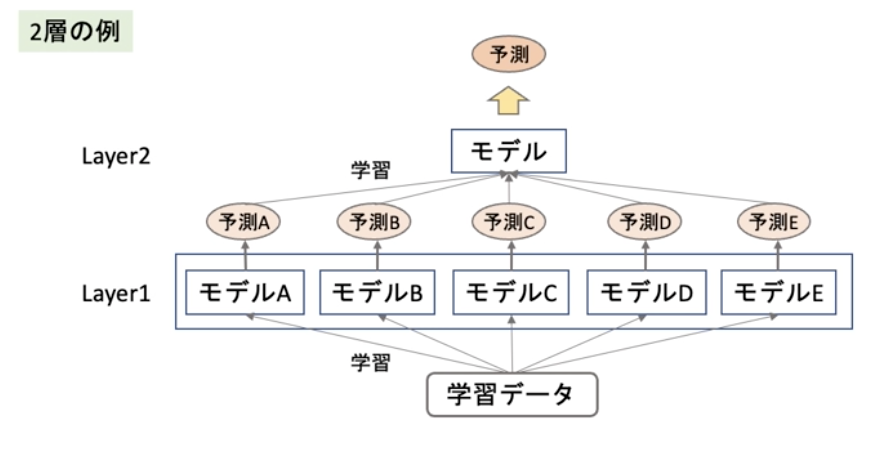

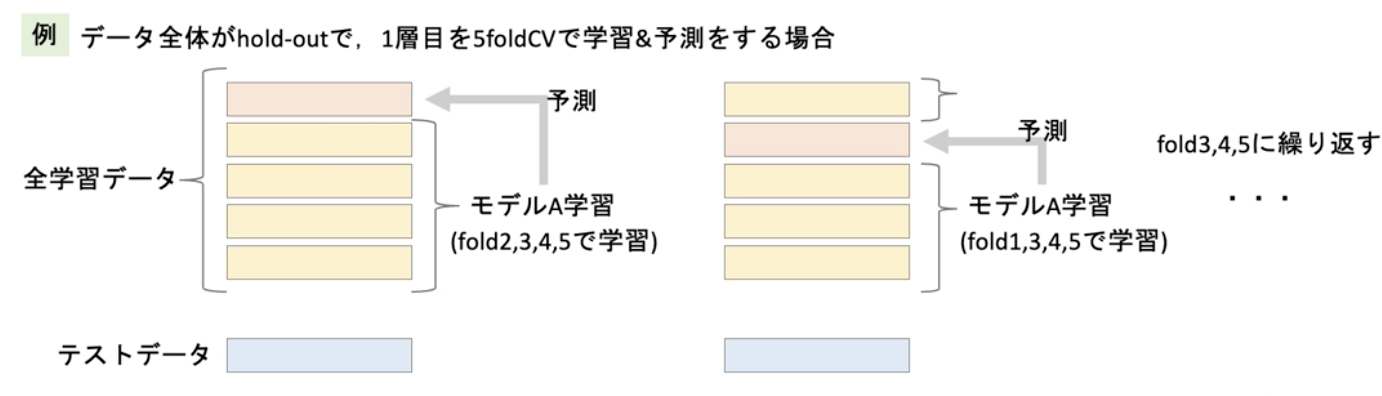

## データ準備

In [24]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
X = oe.fit_transform(X)
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 実装
- StackingClassifierCVクラス
    - 今回は2値分類にのみ対応
    - estimators引数: 1層目のモデルのリスト[('model_name', model), ...]
    - final_estimator引数: 2層目のsklearnモデルインスタンス
    - cv引数: sklearnのCVオブジェクト
    - .fitおよび.predict_probaメソッドを実装

In [10]:
import pandas as pd
class StackingClassifierCV(): # 今回は二値分類にのみ対応
    
    def __init__(self, estimators, final_estimator, cv):
        self.estimators = estimators # [("rf", RandomForest()), ("knn", KNeighborsClassifier())]
        self.final_estimator = final_estimator
        self.cv = cv
        
    def fit(self, X, y):
        pred_features = {}
        # 1層目のモデル学習
        for model_name, model in self.estimators:
            preds = []
            new_y = []
            
            for train_idx, val_idx in self.cv.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                model.fit(X_train, y_train)
                pred = model.predict_proba(X_val)[:, 1].tolist()
                preds += pred 
                # cv.splitによりXの順番が変わっているので，それに合わせて新しくyを作成する
                new_y += y_val.tolist()
            model.fit(X, y)
            pred_features[model_name] = preds
            
        # 2層目のモデル学習
        new_X = pd.DataFrame(pred_features)
        self.final_estimator.fit(new_X, new_y)
        
    def predict_proba(self, X):
        # 1層目のモデルで特徴量(予測値))生成
        pred_features = {}
        for model_name, model in self.estimators:
            pred = model.predict_proba(X)[:, 1]
            pred_features[model_name] = pred
            
        new_X = pd.DataFrame(pred_features)
        final_pred = self.final_estimator.predict_proba(new_X)
        return final_pred
        

In [22]:
# 一層目のモデル
estimators=[('rf', RandomForestClassifier()), ('knn', KNeighborsClassifier()), ('logistic', LogisticRegression())]
# 二層目のモデル
final_estimator = LogisticRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=0)
stacking_cv = StackingClassifierCV(estimators=estimators,
                                   final_estimator=final_estimator,
                                   cv=cv)
stacking_cv.fit(pd.DataFrame(X_train), y_train)
y_pred_stacking_cv = stacking_cv.predict_proba(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

In [23]:
# 評価
print(f"stackingCV AUC: {roc_auc_score(y_test, y_pred_stacking_cv[:, 1])}")

stackingCV AUC: 0.8349358974358975
